In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import the required libraries for web scraping
from bs4 import BeautifulSoup
import requests
import re
import time
import random

In [4]:
# create a list of all possible rolls of 3 dice
rolls = []
for i in range(1,7):
    for j in range(1,7):
        for k in range(1,7):
            rolls.append([i,j,k])

In [5]:
# get all sums that equal 4 or less
sums = []
for roll in rolls:
    if sum(roll) <= 4:
        sums.append(roll)

In [7]:
len(rolls)

216

In [6]:
sums

[[1, 1, 1], [1, 1, 2], [1, 2, 1], [2, 1, 1]]

In [3]:
dota_players = pd.read_csv('data/dota_players.csv')
dota_teams = pd.read_csv('data/dota_teams.csv')
dota_heroes = pd.read_csv('data/dota_heroes.csv')

In [28]:
single_performances = pd.read_csv('data/datdota_singleperformances.csv')

In [63]:
single_performances

,Match,Hero,Player,Result,Kills,Deaths,Assists,GPM,XPM,Last Hits,Denies,LVL,HD,TD,HH,GS,End Game Items
0,7006656045,Beastmaster,Hyko,Win,4,3,15,513,561,194,4,16,9790,7150,2968,14150,Quelling Blade Helm of the Overlord Dust of Ap...
1,7006656045,Bounty Hunter,RedMonster,Loss,0,8,4,185,211,25,0,9,4192,0,0,5015,Wind Lace Magic Wand Orb of Venom Phase Boots ...
2,7006656045,Snapfire,ArzenT,Loss,2,3,5,362,434,149,4,14,11874,478,1332,9660,Guardian Greaves Soul Ring Magic Wand Dust of ...
3,7006656045,Medusa,Rena.-♥,Loss,2,2,2,590,668,334,17,18,12192,887,0,16625,Power Treads Crystalys Wraith Band Dragon Lanc...
4,7006656045,Earth Spirit,ᅚ,Loss,0,9,7,150,188,15,2,9,4564,222,0,4060,Dust of Appearance Magic Wand Vitality Booster...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,6985774788,Treant Protector,Mjz,Win,2,4,19,300,345,21,0,14,8542,112,8392,9090,Magic Wand Force Staff Sentry Ward Blink Dagge...
2496,6985774788,Primal Beast,Oscar,Win,6,0,19,515,678,192,18,20,17074,3279,0,16665,Heaven's Halberd Phase Boots Black King Bar Ag...
2497,6985774788,Dawnbreaker,Frank,Loss,5,5,2,398,444,186,5,16,11301,36,1599,13910,Phase Boots Magic Wand Soul Ring Bracer Desola...
2498,6985774788,Legion Commander,LeoStyle-,Loss,2,7,1,341,393,150,15,15,14808,1915,480,9925,Phase Boots Bracer Magic Wand Blade Mail Blink...


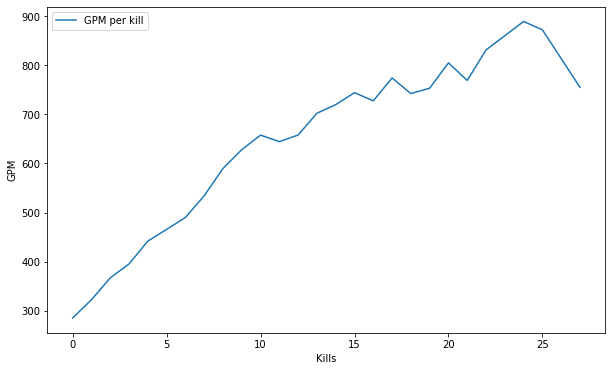

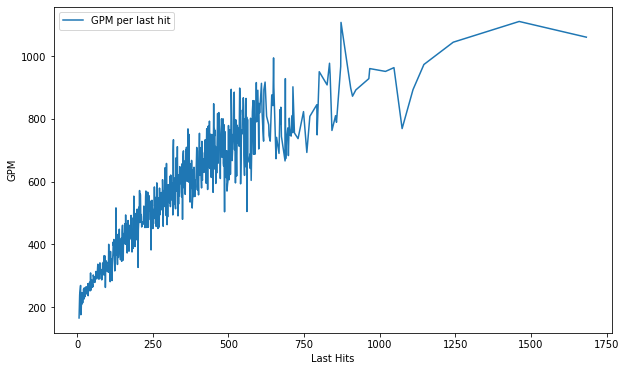

In [92]:
# get a list of how gpm scales with kills and last hits
gpm_kills = single_performances.groupby('Kills')['GPM'].mean()
gpm_lh = single_performances.groupby('Last Hits')['GPM'].mean()
xpm_kills = single_performances.groupby('Kills')['XPM'].mean()
xpm_lh = single_performances.groupby('Last Hits')['XPM'].mean()
xpm_level = single_performances.groupby('LVL')['XPM'].mean()

# plot the data
fig, ax = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax.plot(gpm_kills.index, gpm_kills.values, label='GPM per kill')
ax2.plot(gpm_lh.index, gpm_lh.values, label='GPM per last hit')
ax.set_xlabel('Kills')
ax.set_ylabel('GPM')
ax2.set_xlabel('Last Hits')
ax2.set_ylabel('GPM')
ax2.legend()
ax.legend()
plt.show()

In [33]:
# get the value ranges for all columns in single_performances and put them in a dictionary
value_ranges = {}
value_averages = {}
for col in single_performances.columns:
    if col != 'Match' and col != 'Hero' and col != 'Player' and col != 'Result' and col != 'End Game Items':
        value_ranges[col] = [min(single_performances[col]), max(single_performances[col])]
        value_averages[col] = np.mean(single_performances[col])
value_ranges

{'Kills': [0, 27],
 'Deaths': [0, 20],
 'Assists': [0, 46],
 'GPM': [140, 1110],
 'XPM': [155, 1106],
 'Last Hits': [6, 1683],
 'Denies': [0, 59],
 'LVL': [6, 30],
 'HD': [1723, 115260],
 'TD': [0, 34011],
 'HH': [0, 30899],
 'GS': [2630, 74295]}

In [96]:
xpm_level

LVL
6     175.500000
7     207.000000
8     196.500000
9     217.666667
10    275.545455
11    281.696429
12    309.918919
13    337.037383
14    370.188525
15    405.007874
16    453.235294
17    477.313253
18    519.263682
19    549.000000
20    583.687898
21    618.210843
22    671.686391
23    687.671329
24    729.753731
25    769.104000
26    732.604167
27    780.745098
28    762.017857
29    773.250000
30    792.090909
Name: XPM, dtype: float64

In [6]:
player_options = dota_players['ID'].unique()

In [118]:
# create a class to store single performance data
class SinglePerformance:
    def __init__(
        self,
        match_id,
        player_id,
        hero_id,
        kills,
        deaths,
        assists,
        last_hits,
        denies,
        gpm,
        xpm,
        hero_damage,
        tower_damage,
        hero_healing,
        level,
    ):
        self.match_id = match_id
        self.player_id = player_id
        self.hero_id = hero_id
        self.kills = kills
        self.deaths = deaths
        self.assists = assists
        self.last_hits = last_hits
        self.denies = denies
        self.gpm = gpm
        self.xpm = xpm
        self.hero_damage = hero_damage
        self.tower_damage = tower_damage
        self.hero_healing = hero_healing
        self.level = level

    def get_info(self):
        return {
            "Match": self.match_id,
            "Player": self.player_id,
            "Hero": self.hero_id,
            "Kills": self.kills,
            "Deaths": self.deaths,
            "Assists": self.assists,
            "Last_Hits": self.last_hits,
            "Denies": self.denies,
            "GPM": self.gpm,
            "XPM": self.xpm,
            "Hero_Damage": self.hero_damage,
            "Tower_Damage": self.tower_damage,
            "Hero_Healing": self.hero_healing,
            "Level": self.level,
        }


# create a function to generate random performance data
def generate_random_performance(player_id, hero_id, match_id):
    kills = random.randint(0, 25)
    deaths = random.randint(0, 20)
    assists = random.randint(0, 40)
    last_hits = random.randint(1, 750)
    denies = random.randint(0, 50)
    gpm = random.randint(100, 1000)
    xpm = random.randint(100, 1000)
    hero_damage = random.randint(0, 40000)
    tower_damage = random.randint(0, 10000)
    hero_healing = random.randint(0, 10000)
    level = random.randint(10, 30)

    # adjust the gpm, xpm, and level based on kills and last hit distribution from single_performances
    gpm_kill_values = gpm_kills.values
    xpm_kill_values = xpm_kills.values
    gpm_lh_values = gpm_lh.values
    xpm_lh_values = xpm_lh.values

    gpm = int(gpm_kills[kills] + gpm_lh[last_hits])/2
    xpm = int(xpm_kills[kills] + xpm_lh[last_hits])/2
    xpm_level_values = xpm_level.values
    # find the nearest level to the xpm
    # xpm_level = np.abs(xpm_level_values - xpm).argmin()
    level = np.abs(xpm_level_values - xpm).argmin()

    return SinglePerformance(
        player_id,
        hero_id,
        match_id,
        kills,
        deaths,
        assists,
        last_hits,
        denies,
        gpm,
        xpm,
        hero_damage,
        tower_damage,
        hero_healing,
        level,
    )

In [125]:
sp = generate_random_performance(1, 1, 1)
sp.get_info()

{'Match': 1,
 'Player': 1,
 'Hero': 1,
 'Kills': 16,
 'Deaths': 17,
 'Assists': 39,
 'Last_Hits': 58,
 'Denies': 50,
 'GPM': 503.0,
 'XPM': 624.5,
 'Hero_Damage': 18145,
 'Tower_Damage': 9760,
 'Hero_Healing': 1731,
 'Level': 15}

In [36]:
value_ranges

{'Kills': [0, 27],
 'Deaths': [0, 20],
 'Assists': [0, 46],
 'GPM': [140, 1110],
 'XPM': [155, 1106],
 'Last Hits': [6, 1683],
 'Denies': [0, 59],
 'LVL': [6, 30],
 'HD': [1723, 115260],
 'TD': [0, 34011],
 'HH': [0, 30899],
 'GS': [2630, 74295]}

In [ ]:
regions = ['North America', 'Europe', 'China', 'Southeast Asia', 'South America', 'CIS']

In [ ]:
# function that takes a pandas dataframe and assign a region based on each player country
def assign_region(df):
    df['Region'] = df['country'].apply(lambda x: 'North America' if x in ['United States', 'Canada'] else 'Europe' if x in ['United Kingdom', 'Germany', 'France', 'Spain', 'Italy', 'Netherlands', 'Poland', 'Sweden', 'Denmark', 'Norway', 'Finland', 'Belgium', 'Switzerland', 'Austria', 'Portugal', 'Greece', 'Czech Republic', 'Hungary', 'Romania', 'Bulgaria', 'Serbia', 'Slovenia', 'Bosnia and Herzegovina', 'Croatia', 'Ireland', 'Luxembourg', 'Slovakia', 'Estonia', 'Latvia', 'Lithuania', 'Moldova', 'Montenegro', 'Albania', 'Cyprus', 'Macedonia', 'Malta', 'Ukraine', 'Armenia', 'Azerbaijan', 'Georgia', 'Kazakhstan', 'Russia', 'Turkey', 'Belarus', 'Iceland', 'Liechtenstein', 'Monaco', 'San Marino', 'Vatican City'] else 'China' if x in ['China', 'Hong Kong', 'Taiwan'] else 'Southeast Asia' if x in ['Singapore', 'Malaysia', 'Philippines', 'Indonesia', 'Thailand', 'Vietnam', 'Cambodia', 'Laos', 'Myanmar', 'Brunei'] else 'South America' if x in ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Venezuela', 'Uruguay', 'Bolivia', 'Paraguay', 'Guyana', 'Suriname', 'French Guiana', 'Easter Island', 'Falkland Islands', 'South Georgia and the South Sandwich Islands', 'South Sandwich Islands', 'Antarctica'] else 'CIS' if x in ['Russia', 'Ukraine', 'Belarus', 'Kazakhstan', 'Azerbaijan', 'Armenia', 'Georgia', 'Kyrgyzstan', 'Moldova', 'Tajikistan', 'Turkmenistan', 'Uzbekistan', 'Kosovo', 'Abkhazia', 'South Ossetia'] else 'Other')
    return df

In [ ]:
dota_players = assign_region(dota_active_players)

In [ ]:
# function that detects first occurence of char
def find_first(string, char):
    for i, c in enumerate(string):
        if c == char:
            return i
    return -1

# function that detects last occurence of char
def find_last(string, char):
    for i, c in enumerate(string[::-1]):
        if c == char:
            return len(string) - i - 1
    return -1

In [ ]:
# split the team column into team name and role
dota_players['team_name'] = dota_players['team'].apply(lambda x: x[:find_first(x, '(')].strip())
dota_players['role'] = dota_players['team'].apply(lambda x: x[find_first(x, '(')+1:find_last(x, ')')])
dota_players.drop('team', axis=1, inplace=True)

In [ ]:
roles = ['Support', 'Offlaner', 'Solo Middle', 'Carry', 'Coach']

In [ ]:
# filter the roles
dota_players = dota_players[dota_players['role'].isin(roles)]

### Below is for scraping dota data from liquipedia

In [ ]:
# scrape the data from the website
url = "https://liquipedia.net/dota2/Players_(all)"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
rows = soup.findAll("tr")
# # find the table with the data
# table = soup.find('table', class_='wikitable')

In [ ]:
rows[1]

In [ ]:
indexes = rows[1]
index_values = []
for cell in indexes.find_all("th"):
    index_values.append(cell.get_text().rstrip())
players = []

In [ ]:
index_values

In [ ]:
for row in rows:
    if len(row) > 3:
        player = {}
        cells = row.find_all("td")
        for i in range(0, len(cells)):
            key = index_values[i]
            if key == " Links":
                key = "country"
                value = cells[0].find("a").get("title")
            else:
                value = cells[i].get_text().rstrip()
            player[key] = value
        if len(player) > 0:
            players.append(player)

In [ ]:
player_df = pd.DataFrame(players)

In [ ]:
player_df.rename(
    columns={" Real Name": "name", " Team": "team", " ID": "ID"}, inplace=True
)

In [ ]:
filter_roles = {
    "Carry",
    "Mid",
    "Offlane",
    "Support",
    "Hard Support",
    "Soft Support",
    "Hard",
    "Soft",
    "Hard Carry",
    "Soft Carry",
    "Hard Carry",
    "Solo Middle",
    "Analyst",
    "Caster",
    "Host",
    "Offlaner"
}
# drop the rows that are in the filter_roles
player_df = player_df[~player_df["team"].isin(filter_roles)]

In [ ]:
player_df.to_csv("liquipedia_dota_players.csv", index=False)

In [ ]:
# strip all leading and trailing spaces
player_df = player_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [ ]:
url = "https://liquipedia.net/dota2/Portal:Teams"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
teams = []
divs = soup.find_all('div',class_="panel-box")

In [ ]:


def get_teams():
	url = "https://liquipedia.net/dota2/Portal:Teams"
	page = requests.get(url)
	soup = BeautifulSoup(page.content, "html.parser")
	teams = []
	divs = soup.find_all('div',class_="panel-box")
	templates = soup.find_all('span',class_="team-template-team-standard")
	for team in templates:
		teams.append(team.a['title'])
			
	return teams

In [ ]:
teamdf = pd.DataFrame(get_teams())

In [ ]:
teamdf.to_csv("activeteams.csv")

In [ ]:
print(
    "Min: {}, Max: {}".format(
        dota_performances["GPM"].min(), dota_performances["GPM"].max()
    )
)